In [1]:
import os
from os.path import isfile, isdir, join
import logging

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import contextily
import itertools

import crime_patterns.utilities as utils
import crime_patterns.config as config
import crime_patterns.data_management as dm

from crime_patterns.final import plotting
from crime_patterns.analysis import spatial_regression 

import seaborn
from pysal.viz import splot
from splot.esda import plot_moran

from pysal.explore import esda
from pysal.lib import weights
import libpysal
from libpysal.weights import Queen, Rook, KNN
from numpy.random import seed

from spreg import OLS

%load_ext autoreload
%autoreload 2

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
src = config.SRC
bld = config.BLD
data_raw = src / "data"
data_clean = bld / "python" / "data"
results_dir = bld / "python" / "results" 
plots_dir = bld / "python" / "figures"

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(plots_dir):
    os.makedirs(plots_dir)

In [3]:
## define paths
shapefiles_dir = os.path.join(data_raw, "statistical-gis-boundaries-london", "statistical-gis-boundaries-london", "ESRI")
london_ward_shp_path = os.path.join(shapefiles_dir, "London_Ward.shp")
london_borough_shp_path = os.path.join(shapefiles_dir, "London_Borough_Excluding_MHW.shp")
london_lsoa_shp_path = os.path.join(shapefiles_dir, "LSOA_2011_London_gen_MHW.shp")
london_greater_area_shp_path = os.path.join(data_clean,  "Greater_London_Area.shp")

crime_incidences_path = os.path.join(data_clean, r"city-of-london-burglaries-2019-cleaned.csv") 
imd_ward_shp_path = os.path.join(data_clean, r"IMD_Ward_2019.shp")
imd_lsoa_shp_path = os.path.join(data_clean, r"IMD_LSOA_2019.shp")
burglary_lsoa_shp_path = os.path.join(data_clean, r"MPS_LSOA_Level_burglary_2019.shp")
burglary_ward_shp_path = os.path.join(data_clean, r"MPS_Ward_Level_burglary_2019.shp")


In [4]:
london_lsoa = gpd.read_file(london_lsoa_shp_path)
london_ward = gpd.read_file(london_ward_shp_path)
london_borough = gpd.read_file(london_borough_shp_path)
london_greater_area = gpd.read_file(london_greater_area_shp_path)

In [5]:
imd_ward = gpd.read_file(imd_ward_shp_path)
imd_lsoa = gpd.read_file(imd_lsoa_shp_path)
burglary_ward = gpd.read_file(burglary_ward_shp_path)
burglary_lsoa = gpd.read_file(burglary_lsoa_shp_path)

In [6]:
logger = logging.getLogger(__name__)
# logger.setLevel(logging.INFO)

In [7]:
# data_dir = r"..\crime_patterns\data"
# shapefiles_dir = os.path.join(data_dir, "statistical-gis-boundaries-london", "ESRI")
# london_ward_shp_path = os.path.join(shapefiles_dir, "London_Ward.shp")
# london_borough_shp_path = os.path.join(shapefiles_dir, "London_Borough_Excluding_MHW.shp")
# london_LSOA_shp_path = os.path.join(shapefiles_dir, "LSOA_2011_London_gen_MHW.shp")

# crime_incidence_path = os.path.join(data_dir, r"uk_crime_data_all\2021-01\2021-01-city-of-london-street.csv")
# mps_lsoa_crime_path = os.path.join(data_dir, r"MPS_LSOA_Level_Crime\MPS LSOA Level Crime (Historical).csv")
# cleaned_data_dir = r"C:\Users\Mumu\Desktop\Bonn Econ\Winter22-23\EPP\crime_patterns\bld\python\data"

In [8]:
# london_lsoa = gpd.read_file(london_LSOA_shp_path)
# london_ward = gpd.read_file(london_ward_shp_path)
# london_borough = gpd.read_file(london_borough_shp_path)

In [9]:
# mps_lsoa_burglary_2019_gdf = gpd.read_file(join(cleaned_data_dir, "MPS_LSOA_Level_burglary_2019.shp"))

(<Figure size 800x600 with 1 Axes>, <Axes: >)

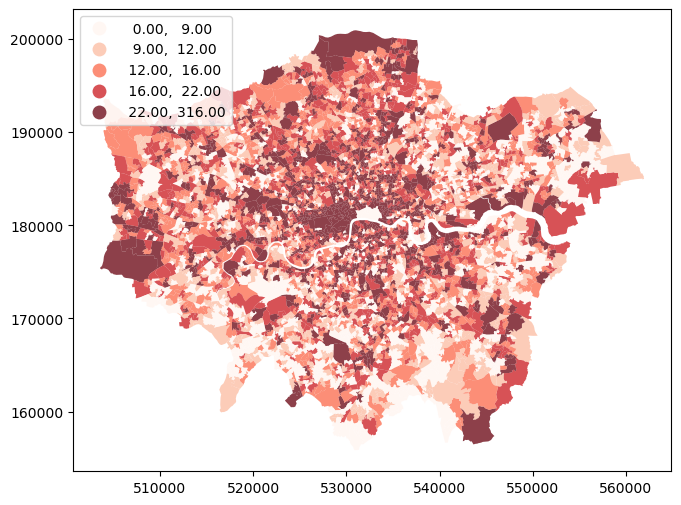

In [12]:
plotting.plot_choropleth_map(burglary_lsoa, column_name="2019_total")

In [13]:
'''
### Global Spatial Autocorrelation
# Do you see any patterns? 
# Are burglaries randomly spread around the map? 
# Or would you say that areas that are closer to each other tend to be more alike? 
# Is there evidence of clustering? 
# Do burglaries seem to appear in certain pockets of the map?

--> Essentially aim to answer the degree to which areas that are near each other tend to be more alike.
--> quantifying whether areas are (on average) alike their neighbours.

'''

'\n### Global Spatial Autocorrelation\n# Do you see any patterns? \n# Are burglaries randomly spread around the map? \n# Or would you say that areas that are closer to each other tend to be more alike? \n# Is there evidence of clustering? \n# Do burglaries seem to appear in certain pockets of the map?\n\n--> Essentially aim to answer the degree to which areas that are near each other tend to be more alike.\n--> quantifying whether areas are (on average) alike their neighbours.\n\n'

In [14]:
w_rook_borough = spatial_regression.create_weights_matrix(london_borough, method="queen", k=5)

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated an

(<Figure size 800x600 with 1 Axes>, <Axes: >)

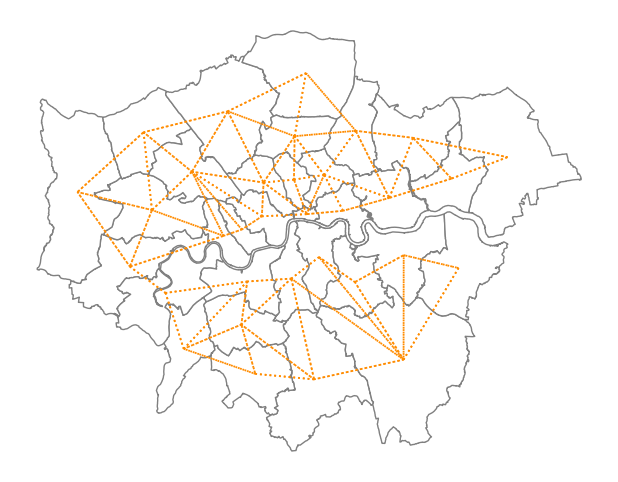

In [15]:
plotting.plot_weights_matrix(london_borough, w_rook_borough, figsize=(8,6))

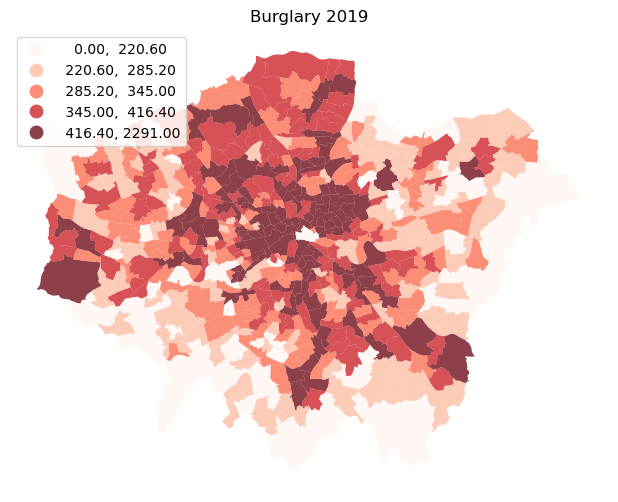

In [16]:
fig, ax = plotting.plot_choropleth_map(burglary_ward, column_name="2019_total")
ax.set_title("Burglary 2019")
ax.set_axis_off()

In [18]:
# w_knn_8_ward = weights.KNN.from_dataframe(london_ward, k=8, ) #ids="GSS_CODE")
# w_knn_8_ward = KNN.from_dataframe(london_ward, k=8, ) #ids="GSS_CODE")
w_knn_8_ward = spatial_regression.create_weights_matrix(burglary_ward, method="knn", k=8)

In [19]:
w_knn_8_ward

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated an

(<Figure size 800x600 with 1 Axes>, <Axes: >)

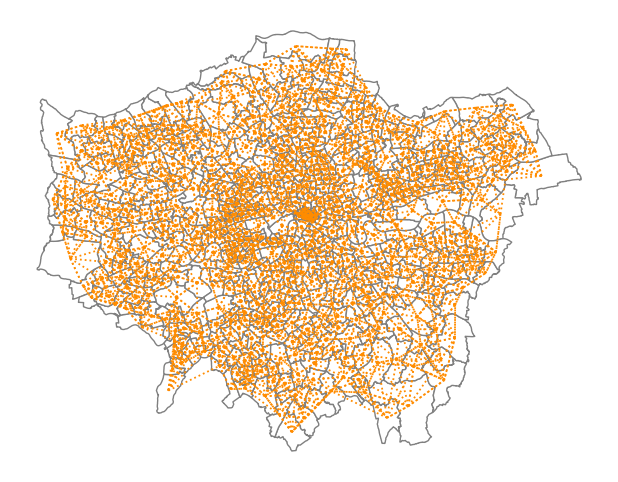

In [20]:
plotting.plot_weights_matrix(london_ward, w_knn_8_ward, figsize=(8,6))

In [21]:
burglary_ward_lag = spatial_regression.calculate_spatial_lag(data=burglary_ward, y_col_name="2019_total", weights_matrix=w_knn_8_ward, ID_column_name="GSS_CODE")

In [22]:
burglary_ward_lag

,2019_total,2019_total_lag,geometry
GSS_CODE,,,
E05000405,73.0,134.500,"POLYGON ((516401.600 160201.800, 516407.300 16..."
E05000414,134.0,134.125,"POLYGON ((517829.600 165447.100, 517837.100 16..."
E05000401,130.0,182.875,"POLYGON ((518107.500 167303.400, 518114.300 16..."
E05000400,140.0,148.500,"POLYGON ((520480.000 166909.800, 520490.700 16..."
E05000402,194.0,208.625,"POLYGON ((522071.000 168144.900, 522063.900 16..."
...,...,...,...
E05000002,0.0,64.500,"POLYGON ((533326.100 181359.400, 533336.900 18..."
E05000008,0.0,44.375,"POLYGON ((532703.800 181263.500, 532707.800 18..."
E05000012,59.0,58.500,"POLYGON ((532880.500 181723.400, 532884.200 18..."


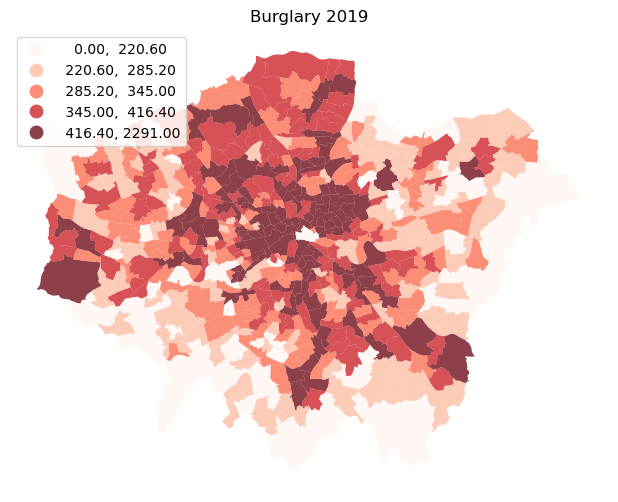

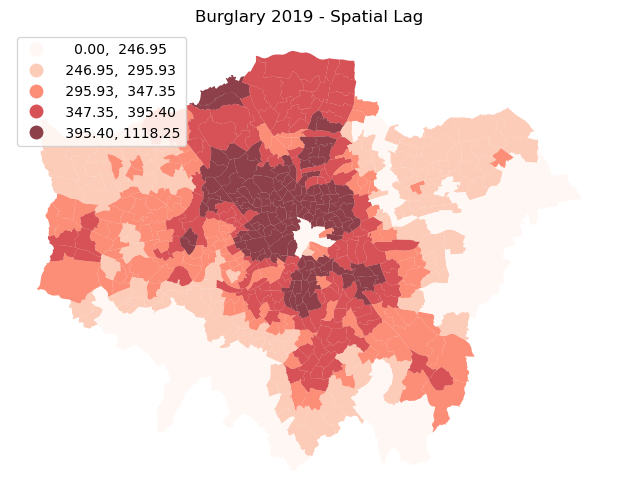

In [15]:
fig, ax = plotting.plot_regional_level_crime(
    region=burglary_ward_lag,
    column_name="2019_total",
    figsize=(8,6),
)
ax.set_title("Burglary 2019")
ax.set_axis_off()

fig, ax = plotting.plot_regional_level_crime(
    region=burglary_ward_lag,
    column_name="2019_total_lag",
    figsize=(8,6),
)
ax.set_title("Burglary 2019 - Spatial Lag")
ax.set_axis_off()

# plt.show()

In [17]:
## Binary case: joint counts
burglary_ward["2019_burglary_maj"] = (burglary_ward["2019_total"] > 313).astype(int)
burglary_ward[["2019_total", "2019_burglary_maj"]].tail()

,2019_total,2019_burglary_maj
GSS_CODE,,
E05000002,0.0,0
E05000008,0.0,0
E05000012,59.0,0
E05000021,118.0,0
E05000009,0.0,0


In [18]:
burglary_ward["2019_total"].median()

313.0

In [19]:
burglary_ward["2019_total"].describe()

count     649.000000
mean      332.599384
std       180.114221
min         0.000000
25%       238.000000
50%       313.000000
75%       396.000000
max      2291.000000
Name: 2019_total, dtype: float64

' \nVisually, it appears that the map represents a clear case of positive spatial autocorrelation: \noverall, there are few visible cases where a given observation is surrounded by others in the opposite category. \n'

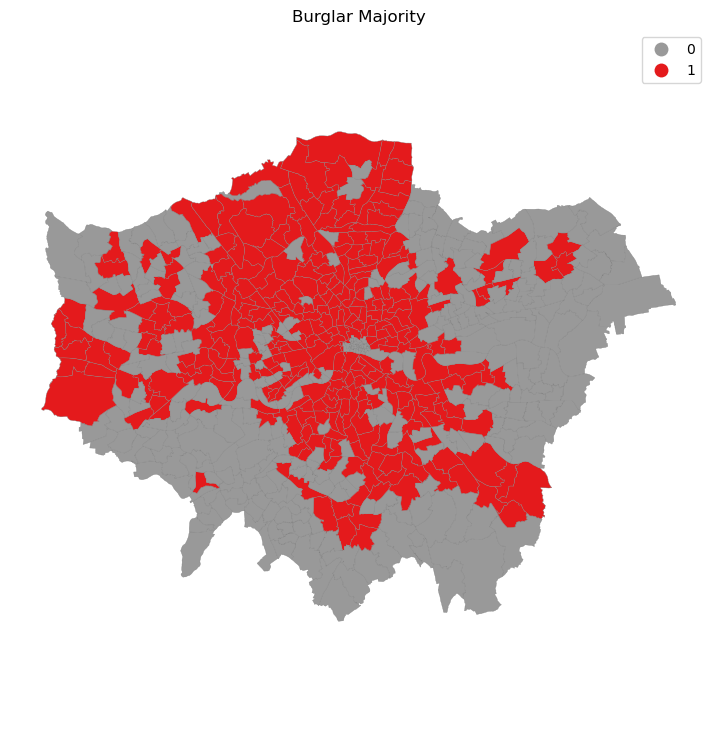

In [21]:
f, ax = plt.subplots(1, figsize=(9, 9))
burglary_ward.plot(
    ax=ax,
    column="2019_burglary_maj",
    categorical=True,
    legend=True,
    edgecolor="0.5",
    linewidth=0.25,
    cmap="Set1_r",
    figsize=(9, 9),
)
ax.set_axis_off()
ax.set_title("Burglar Majority")
plt.axis("equal")
# plt.show()

''' 
Visually, it appears that the map represents a clear case of positive spatial autocorrelation: 
overall, there are few visible cases where a given observation is surrounded by others in the opposite category. 
'''

In [22]:
w_knn_8_ward.transform

'R'

In [58]:
w_knn_8_ward.transform = "O"

In [25]:
w_knn_8_ward.transform

'R'

In [23]:
# burglary_ward["2019_total_std"] = burglary_ward["2019_total"] - burglary_ward["2019_total"].mean()
# burglary_ward["2019_total_lag_std"] = weights.lag_spatial(
#     w_knn_8_ward, burglary_ward["2019_total_std"]
# )

In [24]:
# f, ax = plt.subplots(1, figsize=(6, 6))
# seaborn.regplot(
#     x="2019_total_std",
#     y="2019_total_lag_std",
#     ci=None,
#     data=burglary_ward,
#     line_kws={"color": "r"},
# )
# ax.axvline(0, c="k", alpha=0.5)
# ax.axhline(0, c="k", alpha=0.5)
# ax.set_title("Moran Plot - % Leave")

In [32]:
w_knn_8_ward

In [34]:
type(w_knn_8_ward)

libpysal.weights.distance.KNN

In [53]:
moran = spatial_regression.calculate_morans_I(data=burglary_ward, y_col_name="2019_total", weights_matrix=w_knn_8_ward, transform="R")

In [50]:
moran.I

0.5091156302715855

In [51]:
moran.p_sim

0.001

Text(0, 0.5, 'Burglary - Spatial Lag, 2019')

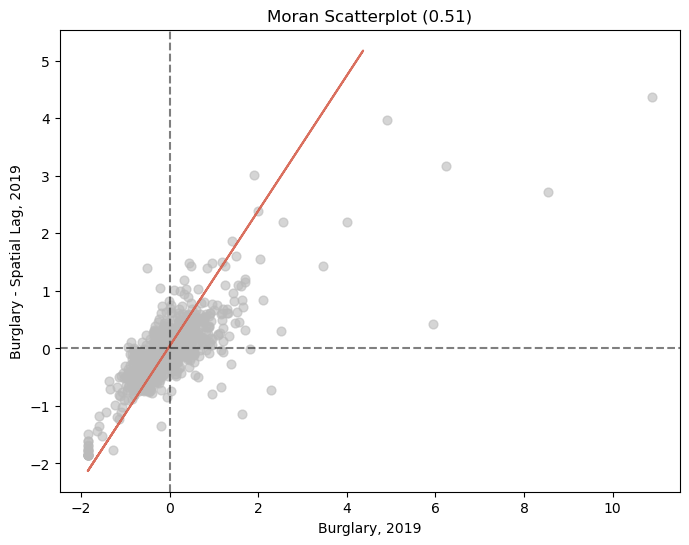

In [59]:
fig, ax = plotting.plot_moran_scatter(moran)

ax.set_xlabel("Burglary, 2019")
ax.set_ylabel("Burglary - Spatial Lag, 2019")

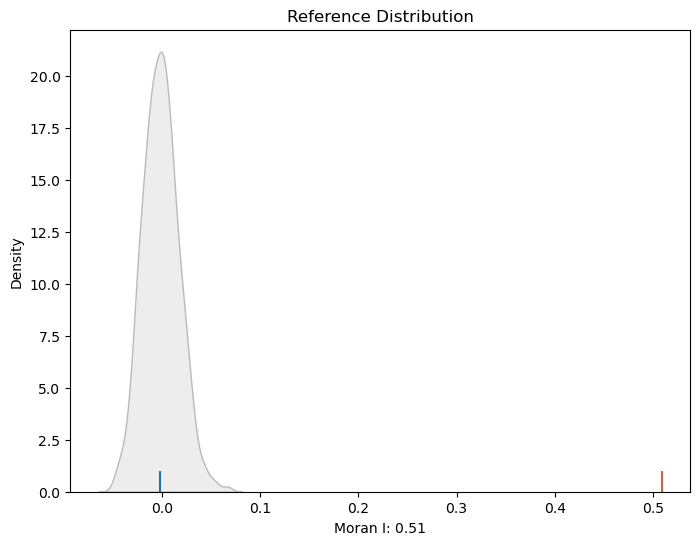

In [60]:
fig, ax = plotting.plot_moran_distribution(moran)

# ax.set_xlabel("Burglary, 2019")
# ax.set_ylabel("Burglary - Spatial Lag, 2019")